In [1]:
import numpy as np
import os
from pathlib import Path

from e.src.lib.placeholders import (
    ParametrosFisicos,
    NpuntosDireccion,
    ParametrosGeometricos,
    ParametrosComputacionales
)

from e.src.lib.constants import Rutas

from e.src.core._typing import (
    DictParametrosLike,
    List,
    Any
)

import logging
from logging import _nameToLevel

dict_log_level : DictParametrosLike = _nameToLevel

# Configurar logger
logger = logging.getLogger('mna')
logger.setLevel(dict_log_level['DEBUG'])

# Añadir un StreamHandler para mostrar los logs en la consola
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.DEBUG)

# Añadir un formato básico para los mensajes de log
formatter = logging.Formatter('%(name)s - %(levelname)s - %(message)s')
console_handler.setFormatter(formatter)

# Añadir el handler al logger
logger.addHandler(console_handler)

In [2]:
# Temperaturas.
ParametrosFisicos.T0 = 0
ParametrosFisicos.T1 = 100

Temperaturas = ParametrosFisicos.parametros_de_la_clase()

# Npuntos en la direccion dada.
NpuntosDireccion.Nx = 5
NpuntosDireccion.Ny = 5

Npuntos = NpuntosDireccion.parametros_de_la_clase()

# Geometria del sistema rectangular | R = { (x, y) | 0 < x < 0.5, 0 < y < 0.5 }.
ParametrosGeometricos.Lx = 0.5
ParametrosGeometricos.Ly = 0.5

Rparams = ParametrosGeometricos.parametros_de_la_clase()

# Parametros computacionales.
ParametrosComputacionales.max_iteraciones = int(1e4)
ParametrosComputacionales.tolerancia = 1e-6

CompParams = ParametrosComputacionales.parametros_de_la_clase()

# Resumen de los parametros.

lista_params_holders: List[List[Any]] = [
    list(Temperaturas.items()),
    list(Npuntos.items()),
    list(Rparams.items()),
    list(CompParams.items())
]

logger.debug(f"Parametros:")
for item in lista_params_holders:
    logger.debug(item)

mna - DEBUG - Parametros:
mna - DEBUG - [('T0', 0), ('T1', 100)]
mna - DEBUG - [('Nx', 5), ('Ny', 5)]
mna - DEBUG - [('Lx', 0.5), ('Ly', 0.5)]
mna - DEBUG - [('max_iteraciones', 10000), ('tolerancia', 1e-06)]


In [3]:
u = np.zeros((Npuntos['Nx'], Npuntos['Ny']))

In [4]:
u

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [5]:
# Condiciones de contorno.

# Lados a T0.
u[:, 0] = Temperaturas['T0']
u[0, :] = Temperaturas['T0']

# Lados a T1.
u[-1, :] = np.linspace(0, Temperaturas['T1'], num=Npuntos['Nx'])
u[:, -1] = np.linspace(0, Temperaturas['T1'], num=Npuntos['Ny'])

In [6]:
u = np.flipud(u)

In [7]:
def jacobi(u, Nx, Ny, tol=1e-6, max_iter=10000):
    
    for iteracion in range(max_iter):
        u_old = np.copy(u)
        
        # Iterar sobre los puntos internos.
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                # Esquema para la ecuacion de Laplace.
                u[i, j] = 0.25 * (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1])
        
        # Criterio de convergencia
        error = np.max(np.abs(u - u_old))
        if error < tol:
            logger.info(f"Convergencia alcanzada después de {iteracion} iteraciones.")
            return u, iteracion
        
    logger.info(f"No se alcanzó la convergencia después de {max_iter} iteraciones.")
    return u, max_iter


def gauss_seidel(u, Nx, Ny, tol=1e-6, max_iter=10000):
    """
    Método de Gauss-Seidel para resolver el sistema de ecuaciones discretizado
    de la ecuación de Laplace.
    
    Args:
    - u: Matriz con las condiciones iniciales de temperatura.
    - Nx: Número de puntos en la dirección x.
    - Ny: Número de puntos en la dirección y.
    - tol: Tolerancia para la convergencia.
    - max_iter: Máximo número de iteraciones.
    
    Returns:
    - u: Matriz con las soluciones aproximadas.
    - iteraciones: Número de iteraciones realizadas.
    """
    for iteracion in range(max_iter):
        max_error = 0.0
        
        # Iterar sobre los puntos internos
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                # Guardar el valor anterior
                u_old = u[i, j]
                
                # Esquema para la ecuación de Laplace
                u[i, j] = 0.25 * (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1])
                
                # Calcular el error máximo
                max_error = max(max_error, abs(u[i, j] - u_old))
        
        
        # Criterio de convergencia
        if max_error < tol:
            print(f"Convergencia alcanzada después de {iteracion} iteraciones.")
            return u, iteracion
        
    print(f"No se alcanzó la convergencia después de {max_iter} iteraciones.")
    return u, max_iter


def gauss_seidel_matriz(A, b, tol=1e-6, max_iter=10000):
    """
    Método de Gauss-Seidel para resolver un sistema lineal Ax = b.
    
    Args:
    - A: Matriz de coeficientes.
    - b: Vector de términos independientes.
    - tol: Tolerancia para la convergencia.
    - max_iter: Máximo número de iteraciones.
    
    Returns:
    - x: Vector solución.
    - iteraciones: Número de iteraciones realizadas.
    """
    n = len(b)
    x = np.zeros_like(b, dtype=np.double)  # Vector inicial de solución
    
    for iteracion in range(max_iter):
        x_old = np.copy(x)
        
        # Iterar sobre cada ecuación del sistema
        for i in range(n):
            sigma = 0
            for j in range(n):
                if i != j:
                    sigma += A[i, j] * x[j]
            
            # Actualizar la solución usando los valores más recientes
            x[i] = (b[i] - sigma) / A[i, i]
        
        # Criterio de convergencia
        error = np.linalg.norm(x - x_old, ord=np.inf)
        if error < tol:
            print(f"Convergencia alcanzada después de {iteracion} iteraciones.")
            return x, iteracion
    
    print(f"No se alcanzó la convergencia después de {max_iter} iteraciones.")
    return x, max_iter


def gauss_seidel_sor(u, Nx, Ny, omega=1.5, tol=1e-6, max_iter=10000):
    
    for iteracion in range(max_iter):
        max_error = 0.0
        
        # Iterar sobre los puntos internos
        for i in range(1, Nx-1):
            for j in range(1, Ny-1):
                # Guardar el valor anterior
                u_old = u[i, j]
                
                # Esquema para la ecuación de Laplace (Gauss-Seidel + Sobrerrelajación)
                u_new = 0.25 * (u[i+1, j] + u[i-1, j] + u[i, j+1] + u[i, j-1])
                
                # Actualización con Sobrerrelajación
                u[i, j] = (1 - omega) * u_old + omega * u_new
                
                # Calcular el error máximo
                max_error = max(max_error, abs(u[i, j] - u_old))
        
        # Criterio de convergencia
        if max_error < tol:
            print(f"Convergencia alcanzada después de {iteracion} iteraciones.")
            return u, iteracion
    
    print(f"No se alcanzó la convergencia después de {max_iter} iteraciones.")
    return u, max_iter

In [8]:
# Aplicar Gauss-Seidel
u_final, iteraciones = gauss_seidel_sor(
    u=u, 
    Nx=Npuntos['Nx'], 
    Ny=Npuntos['Ny'], 
    tol=CompParams['tolerancia'], 
    max_iter=CompParams['max_iteraciones'],
    omega=1.1
)

logger.info(f"Solución después de {iteraciones} iteraciones:")
logger.info(u_final)

mna - INFO - Solución después de 19 iteraciones:
mna - INFO - [[  0.          25.          50.          75.         100.        ]
 [  0.          18.74999972  37.49999976  56.24999989  75.        ]
 [  0.          12.49999976  24.99999979  37.49999991  50.        ]
 [  0.           6.24999989  12.49999991  18.74999996  25.        ]
 [  0.           0.           0.           0.           0.        ]]


Convergencia alcanzada después de 19 iteraciones.


In [9]:
# Voy a crear una lista de resultados de los puntos interiores.
logger.info(f"{'i':2} | {'wi':5}")
logger.info(f"{'-'*20}")
for i in range(1, Npuntos['Nx']-1):
    for j in range(1, Npuntos['Ny']-1):
        # if i != 0 and j != 0 and i != Npuntos['Nx']-1 and j != Npuntos['Ny']-1:
        punto_interior: float = u[i,j]
        logger.info(f"{i} | {u[i,j]:.2f}")

mna - INFO - i  | wi   
mna - INFO - --------------------
mna - INFO - 1 | 18.75
mna - INFO - 1 | 37.50
mna - INFO - 1 | 56.25
mna - INFO - 2 | 12.50
mna - INFO - 2 | 25.00
mna - INFO - 2 | 37.50
mna - INFO - 3 | 6.25
mna - INFO - 3 | 12.50
mna - INFO - 3 | 18.75


In [10]:
u[:, 1]

array([25.        , 18.74999972, 12.49999976,  6.24999989,  0.        ])

In [11]:
u[:, 3]

array([75.        , 56.24999989, 37.49999991, 18.74999996,  0.        ])

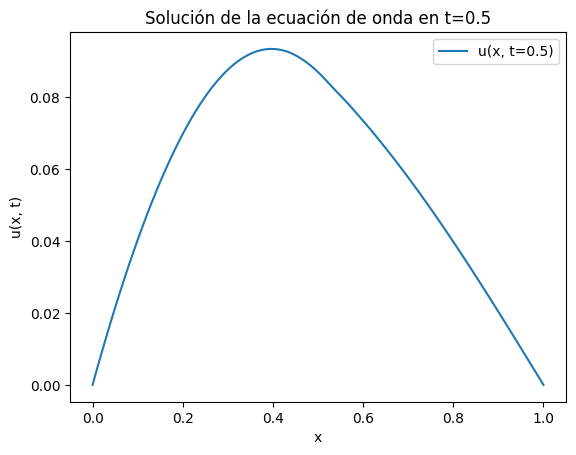

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def solve_wave_eq(Nx, Nt, L, T, cfl):
    """
    Resuelve la ecuación de onda hiperbólica con el esquema explícito en diferencias finitas.
    
    Args:
    - Nx: Número de puntos en la dirección espacial (x).
    - Nt: Número de puntos en la dirección temporal (t).
    - L: Longitud del dominio espacial.
    - T: Tiempo total a simular.
    - cfl: Número de Courant (CFL), define la relación entre dt y dx.
    
    Returns:
    - u: Matriz con las soluciones aproximadas.
    - x: Vector de posiciones espaciales.
    - t: Vector de tiempos.
    """
    # Discretización espacial y temporal
    dx = L / (Nx - 1)
    dt = cfl * dx  # Para mantener la estabilidad, dt <= dx/c
    x = np.linspace(0, L, Nx)
    t = np.linspace(0, T, Nt)
    
    # Coeficiente de estabilidad CFL
    r = (dt / dx)**2
    
    # Inicialización de la solución
    u = np.zeros((Nt, Nx))
    
    # Condiciones iniciales
    u[0, :] = x * (1 - x)  # u(x, 0) = x(1 - x)
    
    # Primera iteración: derivada temporal cero
    u[1, :] = u[0, :]  # u_t(x, 0) = 0 implica que u[1, :] = u[0, :]
    
    # Aplicar condiciones de frontera
    u[:, 0] = 0  # u(0, t) = 0
    u[:, -1] = 0  # u(1, t) = 0
    
    # Iteraciones en el tiempo
    for n in range(1, Nt-1):
        for i in range(1, Nx-1):
            u[n+1, i] = (2 * u[n, i] - u[n-1, i] +
                         r * (u[n, i+1] - 2 * u[n, i] + u[n, i-1]) +
                         dt**2 * (1 - x[i]**2))
    
    return u, x, t

# Parámetros del problema
L = 1.0  # Longitud del dominio en x
T = 1.0  # Tiempo total a simular
Nx = 100  # Número de puntos en x
Nt = 200  # Número de puntos en t
cfl = 0.5  # Número de Courant (debe ser <= 1 para estabilidad)

# Resolver la ecuación de onda
u, x, t = solve_wave_eq(Nx, Nt, L, T, cfl)

# Graficar la solución en un tiempo específico
plt.plot(x, u[100, :], label='u(x, t=0.5)')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.title('Solución de la ecuación de onda en t=0.5')
plt.legend()
plt.show()


In [13]:
import numpy as np

def linear_shape_functions(xi):
    """
    Funciones de forma lineales para elementos finitos.
    """
    N1 = (1 - xi)  # Función de forma en el nodo izquierdo
    N2 = xi        # Función de forma en el nodo derecho
    return N1, N2

def element_stiffness_matrix(h):
    """
    Calcula la matriz de rigidez para un elemento con longitud h.
    """
    return np.array([[1, -1],
                     [-1, 1]]) / h

def element_load_vector(h, x_start):
    """
    Calcula el vector de fuerzas para un elemento con longitud h.
    Incluye el término x en la ecuación diferencial.
    """
    return np.array([h * (x_start + h / 3), h * (x_start + 2 * h / 3)])

def solve_fem_linear(N_elements):
    """
    Solución del problema usando elementos finitos lineales.
    N_elements: Número de elementos finitos.
    """
    L = 1  # Longitud del dominio
    h = L / N_elements  # Tamaño de cada elemento
    N_nodes = N_elements + 1  # Número de nodos

    # Inicializar la matriz global de rigidez y el vector de fuerzas
    K_global = np.zeros((N_nodes, N_nodes))
    f_global = np.zeros(N_nodes)

    # Ensamblar la matriz de rigidez y el vector de fuerzas
    for i in range(N_elements):
        # Indices globales para el elemento actual
        node1 = i
        node2 = i + 1
        
        # Matriz de rigidez elemental
        K_elem = element_stiffness_matrix(h)
        
        # Vector de fuerzas elemental
        f_elem = element_load_vector(h, i * h)
        
        # Ensamblar en la matriz y vector global
        K_global[node1:node2+1, node1:node2+1] += K_elem
        f_global[node1:node2+1] += f_elem

    # Aplicar condiciones de contorno
    # u(0) = 0 -> Eliminar la primera fila y columna
    K_global = K_global[1:, 1:]
    f_global = f_global[1:]

    # Resolver el sistema lineal
    u_solution = np.linalg.solve(K_global, f_global)

    # Añadir la condición de contorno u(0) = 0
    u_solution = np.concatenate(([0], u_solution))
    
    return u_solution

# Solución usando 4 elementos
N_elements = 4
u_4_elements = solve_fem_linear(N_elements)

# Solución usando 8 elementos
N_elements = 8
u_8_elements = solve_fem_linear(N_elements)

# Imprimir resultados
print("Solución con 4 elementos:")
print(u_4_elements)

print("Solución con 8 elementos:")
print(u_8_elements)


import numpy as np

# Valor analítico en x = 1
u_analitico_x1 = (np.sin(1) / np.cos(1)) - 1
print(f"Valor analítico de u(1): {u_analitico_x1}")


Solución con 4 elementos:
[0.         0.24479167 0.45833333 0.609375   0.66666667]
Solución con 8 elementos:
[0.         0.12434896 0.24479167 0.35742188 0.45833333 0.54361979
 0.609375   0.65169271 0.66666667]
Valor analítico de u(1): 0.5574077246549021


In [14]:
import numpy as np

# Valor analítico en x = 1
u_analitico_x1 = (np.sin(1) / np.cos(1)) - 1
print(f"Valor analítico de u(1): {u_analitico_x1}")


Valor analítico de u(1): 0.5574077246549021


In [15]:
import numpy as np

def linear_shape_functions(xi):
    """
    Funciones de forma lineales para elementos finitos.
    """
    N1 = (1 - xi)  # Función de forma en el nodo izquierdo
    N2 = xi        # Función de forma en el nodo derecho
    return N1, N2

def element_stiffness_matrix(h):
    """
    Calcula la matriz de rigidez para un elemento con longitud h.
    """
    return np.array([[1, -1],
                     [-1, 1]]) / h

def element_load_vector(h, x_start):
    """
    Calcula el vector de fuerzas para un elemento con longitud h.
    Incluye el término x en la ecuación diferencial.
    """
    return np.array([h * (x_start + h / 3), h * (x_start + 2 * h / 3)])

def solve_fem_linear(N_elements):
    """
    Solución del problema usando elementos finitos lineales.
    N_elements: Número de elementos finitos.
    """
    L = 1  # Longitud del dominio
    h = L / N_elements  # Tamaño de cada elemento
    N_nodes = N_elements + 1  # Número de nodos

    # Inicializar la matriz global de rigidez y el vector de fuerzas
    K_global = np.zeros((N_nodes, N_nodes))
    f_global = np.zeros(N_nodes)

    # Ensamblar la matriz de rigidez y el vector de fuerzas
    for i in range(N_elements):
        # Indices globales para el elemento actual
        node1 = i
        node2 = i + 1
        
        # Matriz de rigidez elemental
        K_elem = element_stiffness_matrix(h)
        
        # Vector de fuerzas elemental
        f_elem = element_load_vector(h, i * h)
        
        # Ensamblar en la matriz y vector global
        K_global[node1:node2+1, node1:node2+1] += K_elem
        f_global[node1:node2+1] += f_elem

    # Aplicar condiciones de contorno
    # u(0) = 0 -> Eliminar la primera fila y columna
    K_global = K_global[1:, 1:]
    f_global = f_global[1:]

    # Resolver el sistema lineal
    u_solution = np.linalg.solve(K_global, f_global)

    # Añadir la condición de contorno u(0) = 0
    u_solution = np.concatenate(([0], u_solution))
    
    return u_solution

# Solución usando 4 elementos
N_elements = 4
u_4_elements = solve_fem_linear(N_elements)

# Solución usando 8 elementos
N_elements = 8
u_8_elements = solve_fem_linear(N_elements)

# Valor analítico en x = 1
u_analitico_x1 = (np.sin(1) / np.cos(1)) - 1

# Comparar con el valor numérico en x = 1 para 4 y 8 elementos
u_num_x1_4_elements = u_4_elements[-1]  # Último valor en el dominio (x = 1)
u_num_x1_8_elements = u_8_elements[-1]

# Calcular el error
error_4_elements = abs(u_analitico_x1 - u_num_x1_4_elements)
error_8_elements = abs(u_analitico_x1 - u_num_x1_8_elements)

# Imprimir resultados
print("Valor analítico de u(1):", u_analitico_x1)
print("Solución numérica con 4 elementos en x = 1:", u_num_x1_4_elements)
print("Solución numérica con 8 elementos en x = 1:", u_num_x1_8_elements)
print("Error con 4 elementos:", error_4_elements)
print("Error con 8 elementos:", error_8_elements)


Valor analítico de u(1): 0.5574077246549021
Solución numérica con 4 elementos en x = 1: 0.6666666666666662
Solución numérica con 8 elementos en x = 1: 0.6666666666666666
Error con 4 elementos: 0.10925894201176412
Error con 8 elementos: 0.10925894201176456


In [17]:
import sympy as sp

# Definir la variable independiente
x = sp.symbols('x')

# Definir la función u(x)
u = sp.Function('u')(x)

# Ecuación diferencial
eq = sp.Eq(sp.diff(u, x, 2) + u + x, 0)

# Resolver la ecuación diferencial
sol = sp.dsolve(eq, u)

# Mostrar la solución general
print("Solución general:")
sp.pprint(sol)

# Aplicar las condiciones de contorno u(0) = 0 y du/dx(1) = 0
# Condición u(0) = 0
C1, C2 = sp.symbols('C1 C2')
sol = sol.subs([(u.subs(x, 0), 0)])

# Derivada de la solución
du_dx = sp.diff(sol.rhs, x)

# Condición du/dx(1) = 0
sol = sp.solve([du_dx.subs(x, 1), sol.rhs.subs(x, 0)], [C1, C2])

# Solución analítica con las condiciones de contorno
print("\nSolución con condiciones de contorno:")
sp.pprint(sol)

Solución general:
u(x) = C₁⋅sin(x) + C₂⋅cos(x) - x

Solución con condiciones de contorno:
⎧      1          ⎫
⎨C₁: ──────, C₂: 0⎬
⎩    cos(1)       ⎭


In [21]:
import numpy as np

def element_stiffness_matrix(h):
    """
    Calcula la matriz de rigidez para un elemento con longitud h.
    """
    return np.array([[1, -1],
                     [-1, 1]]) / h

def element_load_vector(h, x_start):
    """
    Calcula el vector de fuerzas para un elemento con longitud h.
    Incluye el término no homogéneo x en la ecuación diferencial.
    """
    # Integración del término f(x) = x
    return np.array([h * (x_start + h / 3), h * (x_start + 2 * h / 3)])

def solve_fem_linear(N_elements):
    """
    Solución del problema usando elementos finitos lineales.
    N_elements: Número de elementos finitos.
    """
    L = 1  # Longitud del dominio
    h = L / N_elements  # Tamaño de cada elemento
    N_nodes = N_elements + 1  # Número de nodos

    # Inicializar la matriz global de rigidez y el vector de fuerzas
    K_global = np.zeros((N_nodes, N_nodes))
    f_global = np.zeros(N_nodes)

    # Ensamblar la matriz de rigidez y el vector de fuerzas
    for i in range(N_elements):
        # Índices globales para el elemento actual
        node1 = i
        node2 = i + 1
        
        # Matriz de rigidez elemental
        K_elem = element_stiffness_matrix(h)
        
        # Vector de fuerzas elemental
        f_elem = element_load_vector(h, i * h)
        
        # Ensamblar en la matriz y vector global
        K_global[node1:node2+1, node1:node2+1] += K_elem
        f_global[node1:node2+1] += f_elem

    # Aplicar condiciones de contorno
    # u(0) = 0 -> Eliminar la primera fila y columna
    K_global = K_global[1:, 1:]
    f_global = f_global[1:]

    # Resolver el sistema lineal
    u_solution = np.linalg.solve(K_global, f_global)

    # Añadir la condición de contorno u(0) = 0
    u_solution = np.concatenate(([0], u_solution))
    
    return u_solution

# Valor analítico en x = 1
u_analitico_x1 = (np.sin(1) / np.cos(1)) - 1

# Solución usando 4 elementos
N_elements = 4
u_4_elements = solve_fem_linear(N_elements)

# Solución usando 8 elementos
N_elements = 8
u_8_elements = solve_fem_linear(N_elements)

# Comparar con el valor numérico en x = 1 para 4 y 8 elementos
u_num_x1_4_elements = u_4_elements[-1]  # Último valor en el dominio (x = 1)
u_num_x1_8_elements = u_8_elements[-1]

# Calcular el error
error_4_elements = abs(u_analitico_x1 - u_num_x1_4_elements)
error_8_elements = abs(u_analitico_x1 - u_num_x1_8_elements)

# Imprimir resultados
print(f"Valor analítico de u(1): {u_analitico_x1}")
print(f"Solución numérica con 4 elementos en x = 1: {u_num_x1_4_elements}")
print(f"Solución numérica con 8 elementos en x = 1: {u_num_x1_8_elements}")
print(f"Error con 4 elementos: {error_4_elements}")
print(f"Error con 8 elementos: {error_8_elements}")


Valor analítico de u(1): 0.5574077246549021
Solución numérica con 4 elementos en x = 1: 0.6666666666666662
Solución numérica con 8 elementos en x = 1: 0.6666666666666666
Error con 4 elementos: 0.10925894201176412
Error con 8 elementos: 0.10925894201176456


In [6]:
import numpy as np

def solucion_analitica(x, t):
    """
    Calcula la solución analítica de la ecuación de onda usando el método de características.
    
    Args:
    - x: posición espacial.
    - t: tiempo.
    
    Returns:
    - u: valor de u(x, t) basado en la solución analítica.
    """
    # Características para el punto R (x - t, x + t)
    x_plus_t = x + t
    x_minus_t = x - t
    
    # Solución particular u_p(x) = (x^2)/2 - (x^4)/12
    def u_p(x):
        return (x**2) / 2 - (x**4) / 12
    
    # Solución inicial en t=0, u(x, 0) = x(1 - x)
    def u_inicial(x):
        return x * (1 - x)
    
    # Método de D'Alembert
    if 0 <= x_plus_t <= 1 and 0 <= x_minus_t <= 1:
        u_h = 0.5 * (u_inicial(x_plus_t) + u_inicial(x_minus_t))
    else:
        u_h = 0  # Fuera del dominio, se asume 0
    
    # Solución total u(x, t)
    u = u_h + u_p(x)
    return u

# Punto R(0.3, 0.1)
x_r = 0.3
t_r = 0.1
u_analitico = solucion_analitica(x_r, t_r)
print(f"Solución analítica en el punto R(0.3, 0.1): {u_analitico}")


Solución analítica en el punto R(0.3, 0.1): 0.24432500000000001


In [7]:
def solve_wave_eq(Nx, Nt, L, T, cfl):
    """
    Resuelve la ecuación de onda hiperbólica con el esquema explícito en diferencias finitas.
    
    Args:
    - Nx: Número de puntos en la dirección espacial (x).
    - Nt: Número de puntos en la dirección temporal (t).
    - L: Longitud del dominio espacial.
    - T: Tiempo total a simular.
    - cfl: Número de Courant (CFL), define la relación entre dt y dx.
    
    Returns:
    - u: Matriz con las soluciones aproximadas.
    - x: Vector de posiciones espaciales.
    - t: Vector de tiempos.
    """
    # Discretización espacial y temporal
    dx = L / (Nx - 1)
    dt = cfl * dx  # Para mantener la estabilidad, dt <= dx/c
    x = np.linspace(0, L, Nx)
    t = np.linspace(0, T, Nt)
    
    # Coeficiente de estabilidad CFL
    r = (dt / dx)**2
    
    # Inicialización de la solución
    u = np.zeros((Nt, Nx))
    
    # Condiciones iniciales
    u[0, :] = x * (1 - x)  # u(x, 0) = x(1 - x)
    
    # Primera iteración: derivada temporal cero
    u[1, :] = u[0, :]  # u_t(x, 0) = 0 implica que u[1, :] = u[0, :]
    
    # Aplicar condiciones de frontera
    u[:, 0] = 0  # u(0, t) = 0
    u[:, -1] = 0  # u(1, t) = 0
    
    # Iteraciones en el tiempo
    for n in range(1, Nt-1):
        for i in range(1, Nx-1):
            u[n+1, i] = (2 * u[n, i] - u[n-1, i] +
                         r * (u[n, i+1] - 2 * u[n, i] + u[n, i-1]) +
                         dt**2 * (1 - x[i]**2))
    
    return u, x, t

# Parámetros de la malla
Nx = 100  # Número de puntos espaciales
Nt = 200  # Número de puntos temporales
L = 1.0   # Longitud del dominio espacial
T = 0.1   # Tiempo total a simular
cfl = 0.5 # Número de Courant

# Resolver la ecuación de onda
u_numerico, x, t = solve_wave_eq(Nx, Nt, L, T, cfl)

# Índices del punto R (0.3, 0.1)
dx = L / (Nx - 1)
dt = cfl * dx
i_R = int(0.3 / dx)
n_R = int(0.1 / dt)

# Solución numérica en el punto R
u_numerico_R = u_numerico[n_R, i_R]
print(f"Solución numérica en el punto R(0.3, 0.1): {u_numerico_R}")


Solución numérica en el punto R(0.3, 0.1): 0.20237934233143487


In [8]:
# Comparación
error = abs(u_analitico - u_numerico_R)
print(f"Error absoluto en el punto R(0.3, 0.1): {error}")


Error absoluto en el punto R(0.3, 0.1): 0.041945657668565145


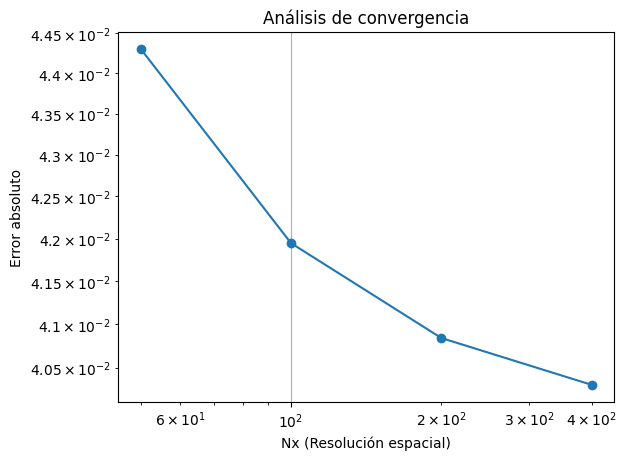

In [9]:
import matplotlib.pyplot as plt

def calcular_error(Nx, Nt, L, T, cfl, x_r, t_r, u_analitico):
    u_numerico, x, t = solve_wave_eq(Nx, Nt, L, T, cfl)
    dx = L / (Nx - 1)
    dt = cfl * dx
    i_R = int(x_r / dx)
    n_R = int(t_r / dt)
    u_numerico_R = u_numerico[n_R, i_R]
    return abs(u_analitico - u_numerico_R)

# Valores de Nx y Nt para el análisis de convergencia
Nx_values = [50, 100, 200, 400]
errors = []

for Nx in Nx_values:
    Nt = 2 * Nx  # Relación fija entre Nt y Nx
    error = calcular_error(Nx, Nt, L, T, cfl, x_r, t_r, u_analitico)
    errors.append(error)

# Graficar el error vs Nx
plt.figure()
plt.loglog(Nx_values, errors, '-o')
plt.xlabel('Nx (Resolución espacial)')
plt.ylabel('Error absoluto')
plt.title('Análisis de convergencia')
plt.grid(True)
plt.show()


In [1]:
import numpy as np

a = np.linspace(0, 1, num=5)

In [2]:
a

array([0.  , 0.25, 0.5 , 0.75, 1.  ])

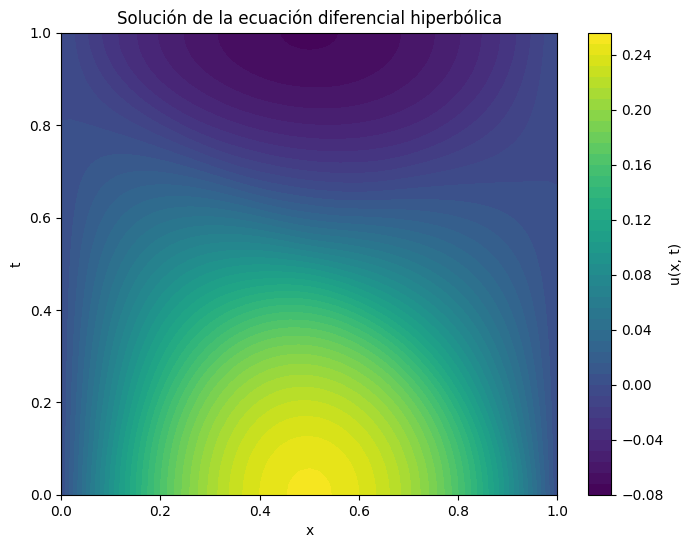

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def resolver_onda_hiperbolica(Nx, Nt, L, T):
    # Parámetros de discretización
    dx = L / Nx
    dt = T / Nt
    x = np.linspace(0, L, Nx + 1)
    t = np.linspace(0, T, Nt + 1)
    sigma = (dt / dx) ** 2

    # Inicializar la matriz de soluciones
    u = np.zeros((Nt + 1, Nx + 1))

    # Condición inicial u(x, 0) = x(1 - x)
    u[0, :] = x * (1 - x)

    # Condición inicial de la derivada temporal es cero
    # Calculamos u[1, :] usando la aproximación:
    for i in range(1, Nx):
        u[1, i] = u[0, i] + 0.5 * sigma * (
            u[0, i+1] - 2*u[0, i] + u[0, i-1] + dx**2 * (1 - x[i]**2)
        )

    # Aplicar condiciones de frontera
    u[:, 0] = 0  # u(0, t) = 0
    u[:, Nx] = 0  # Suponiendo u(L, t) = 0

    # Bucle de tiempo
    for n in range(1, Nt):
        for i in range(1, Nx):
            u[n+1, i] = (
                2*u[n, i] - u[n-1, i] + sigma * (
                    u[n, i+1] - 2*u[n, i] + u[n, i-1] + dx**2 * (1 - x[i]**2)
                )
            )

        # Aplicar condiciones de frontera en cada paso temporal
        u[n+1, 0] = 0
        u[n+1, Nx] = 0

    return x, t, u

# Parámetros del problema
L = 1.0   # Longitud espacial
T = 1.0   # Tiempo total
Nx = 50   # Número de divisiones espaciales
Nt = 100  # Número de pasos temporales

x, t, u = resolver_onda_hiperbolica(Nx, Nt, L, T)

# Visualización
plt.figure(figsize=(8, 6))
X, T_grid = np.meshgrid(x, t)
plt.contourf(X, T_grid, u, levels=50, cmap='viridis')
plt.colorbar(label='u(x, t)')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Solución de la ecuación diferencial hiperbólica')
plt.show()



In [5]:
# Definir el punto de interés
x_point = 0.3
t_point = 0.1

# Encontrar el índice más cercano a x_point en la malla de x
x_idx = np.argmin(np.abs(x - x_point))

# Encontrar el índice más cercano a t_point en la malla de t
t_idx = np.argmin(np.abs(t - t_point))

# Obtener el valor de u en esos índices
u_value = u[t_idx, x_idx]

print(f"El valor de u({x_point}, {t_point}) es aproximadamente: {u_value}")

El valor de u(0.3, 0.1) es aproximadamente: 0.20454174999999986
